In [1]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt

import os
import stats
import pystan

import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import entropy 

import smoothing
import conversion
import plotting

#import misc



In [328]:
# set experiment parameters

first_year = 1992
last_year = 2012
use_body = False
exclude_irrelevant = False

time_window_days = 14

data_dir = '.'
#data_file = os.path.join(data_dir, 'immigration_with_metadata_2017_05_25.csv')
#polls_file = os.path.join(data_dir, 'immigration_polls_dedup_merge.csv')
data_file = os.path.join(data_dir, 'guncontrol_with_metadata_2017_05_25.csv')
polls_file = os.path.join(data_dir, 'gun_control_for_wcalc_corrected.csv')
#data_file = os.path.join(data_dir, 'ssm_with_metadata_2017_05_25.csv')
#polls_file = os.path.join(data_dir, 'samesex_marriage_polls.csv')



In [329]:
# declare frame names
FRAMES = ['Economic',
         'Capacity_and_resources',
         'Morality',
         'Fairness_and_equality',
         'Legality_jurisdiction',
         'Policy_prescription',
         'Crime_and_punishment',
         'Security_and_defense',
         'Health_and_safety',
         'Quality_of_life',
         'Cultural_identity',
         'Public_sentiment',
         'Political',
         'External_regulation',
         'Other']

named_cols = FRAMES + ['Pro', 'Neutral', 'Anti', 'tone', 'stories']

In [330]:
def rename_framing_columns(df, use_body=False):
    columns = list(df.columns)
    for f_i, f in enumerate(FRAMES):
        if use_body:
            col_index = columns.index('b' + str(f_i))
        else:
            col_index = columns.index('p' + str(f_i))
        columns[col_index] = f
    df2 = df.copy()
    df2.columns = columns
    return df2

def interact_framing_and_tone(df):
    df2 = df.copy()
    for f in FRAMES:
        for t in ['Pro', 'Anti']:
            col = f + '_' + t
            df2[col] = df[f] * df[t]
    return df2



In [331]:
# load framing and tone data
reload(conversion)

# read in the csv file
data = pd.read_csv(data_file, header=0, index_col=0)

# subselect based on rows (and irrelevant)
data = data.loc[(data['Year'] >= first_year) & (data['Year'] <= last_year)]
if exclude_irrelevant:
    data = data.loc[data['Irrelevant']==0]

# create a proper date column
data['date'] = conversion.ymd_to_dates(data['Year'].ravel(), data['Month'].ravel(), data['Day'].ravel())

# count each row as one story
data['stories'] = 1

# compute tone
data['tone'] = data['Pro'] - data['Anti']

# rename p0 or b0 to proper frames
data = rename_framing_columns(data, use_body)
data = interact_framing_and_tone(data)

print "Loaded data for %d articles" % len(data.index)

Loaded data for 34289 articles


In [332]:
# plot tone and frames by tone
reload(conversion)

group_by = 'week'

data['period'] = conversion.dates_to_periods(data['date'], first_year, period=group_by)
groups = data.groupby('period')
grouped = pd.DataFrame()
grouped['stories'] = groups.aggregate(np.sum)['stories']
grouped['tone'] = groups.aggregate(np.mean)['tone']
for t in ['Pro', 'Anti']:        
    grouped[t] = groups.aggregate(np.mean)[t]
for f in FRAMES:
    grouped[f] = groups.aggregate(np.mean)[f]
    for t in ['Pro', 'Anti']:        
        col = f + '_' + t
        grouped[col] = groups.aggregate(np.mean)[col]
periods = grouped.index
grouped['f_date'] = conversion.periods_to_f_dates(periods, first_year, period=group_by)
grouped['period'] = grouped.index

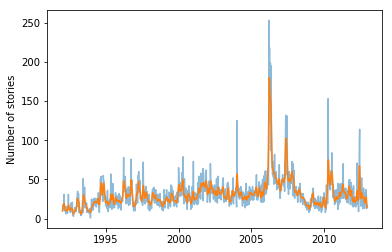

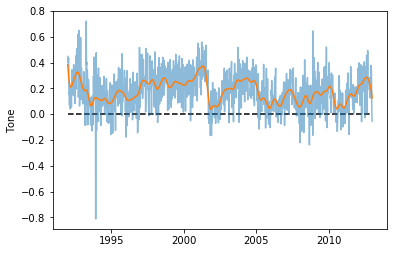

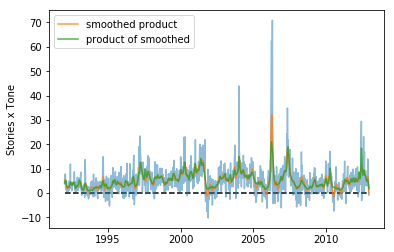

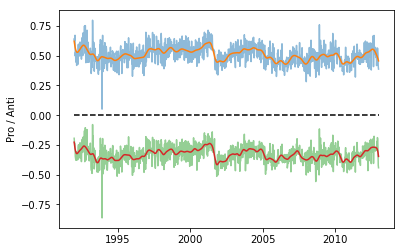

In [334]:
fig, ax = plt.subplots()
#stories_smooth = smoothing.local_linear(x=grouped.f_date, y=grouped.stories, pred_range=grouped.f_date, bw=[0.3])
stories_smooth = smoothing.local_linear(x=grouped.f_date, y=grouped.stories, pred_range=grouped.f_date)
grouped['stories_smooth'] = stories_smooth
ax.plot(grouped.f_date, grouped.stories, alpha=0.5)
ax.plot(grouped.f_date, grouped.stories_smooth)
ax.set_ylabel('Number of stories')

fig, ax = plt.subplots()
tone_smooth = smoothing.local_linear(x=grouped.f_date, y=grouped.tone, pred_range=grouped.f_date, bw='cv_ls')
grouped['tone_smooth'] = tone_smooth
ax.plot([np.min(grouped.f_date), np.max(grouped.f_date)], (0, 0), 'k--')
ax.plot(grouped.f_date, grouped.tone, alpha=0.5)
ax.plot(grouped.f_date, grouped.tone_smooth)
ax.set_ylabel('Tone')

fig, ax = plt.subplots()
toneXstories_smooth = smoothing.local_linear(x=grouped.f_date, y=(grouped.tone * grouped.stories), pred_range=grouped.f_date, bw='cv_ls')
grouped['toneXstories_smooth'] = toneXstories_smooth
ax.plot([np.min(grouped.f_date), np.max(grouped.f_date)], (0, 0), 'k--')
ax.plot(grouped.f_date, (grouped.tone * grouped.stories), alpha=0.5)
ax.plot(grouped.f_date, grouped.toneXstories_smooth, alpha=0.8, label='smoothed product')
ax.plot(grouped.f_date, grouped.tone_smooth * grouped.stories_smooth, alpha=0.8, label='product of smoothed')
ax.legend(loc='upper left')
ax.set_ylabel('Stories x Tone')

fig, ax = plt.subplots()
pro_smooth = smoothing.local_linear(x=grouped.f_date, y=grouped.Pro, pred_range=grouped.f_date, bw='cv_ls')
grouped['Pro_smooth'] = pro_smooth
anti_smooth = smoothing.local_linear(x=grouped.f_date, y=grouped.Anti, pred_range=grouped.f_date, bw='cv_ls')
grouped['Anti_smooth'] = anti_smooth
ax.plot([np.min(grouped.f_date), np.max(grouped.f_date)], (0, 0), 'k--')
ax.plot(grouped.f_date, grouped.Pro, alpha=0.5)
ax.plot(grouped.f_date, grouped.Pro_smooth)
ax.plot(grouped.f_date, -grouped.Anti, alpha=0.5)
ax.plot(grouped.f_date, -grouped.Anti_smooth)
ax.set_ylabel('Pro / Anti')



In [338]:
# do frame smoothing:
for f in FRAMES:
    for t in ['Pro', 'Anti']:
        col = f + '_' + t
        print col
        smoothed = smoothing.local_linear(x=grouped.f_date, y=grouped[col], pred_range=grouped.f_date)
        grouped[col + '_smooth'] = smoothed

Economic_Pro
Economic_Anti
Capacity_and_resources_Pro
Capacity_and_resources_Anti
Morality_Pro
Morality_Anti
Fairness_and_equality_Pro
Fairness_and_equality_Anti
Legality_jurisdiction_Pro
Legality_jurisdiction_Anti
Policy_prescription_Pro
Policy_prescription_Anti
Crime_and_punishment_Pro
Crime_and_punishment_Anti
Security_and_defense_Pro
Security_and_defense_Anti
Health_and_safety_Pro
Health_and_safety_Anti
Quality_of_life_Pro
Quality_of_life_Anti
Cultural_identity_Pro
Cultural_identity_Anti
Public_sentiment_Pro
Public_sentiment_Anti
Political_Pro
Political_Anti
External_regulation_Pro
External_regulation_Anti
Other_Pro
Other_Anti


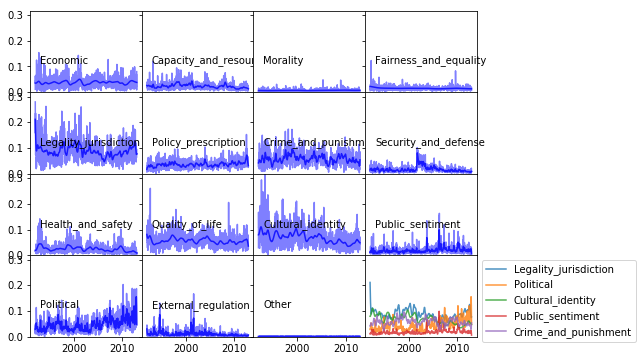

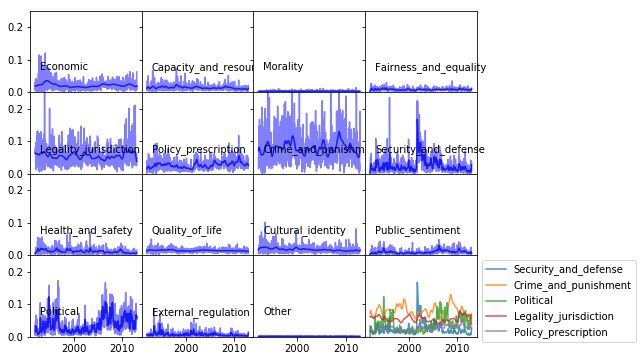

In [339]:

for t in ['Pro', 'Anti']:
    ymax = 0
    maxes = np.zeros(len(FRAMES))
    f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8,6))
    axes = (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15)
    
    for k, frame in enumerate(FRAMES):
        x = grouped.f_date
        n = grouped.stories_smooth
        col = frame + '_' + t
        y = grouped[col].values 
        y_smooth = grouped[col + '_smooth'].values 
        ymax = max(ymax, np.max(y_smooth))
        maxes[k] = np.max(y_smooth)
        axes[k].plot(x, y, c='blue', alpha=0.5)
        axes[k].plot(x, y_smooth, c='blue', alpha=0.8)

    for k, frame in enumerate(FRAMES):
        x = grouped.f_date
        axes[k].set_ylim(0, ymax*1.5)
        axes[k].text(np.min(x)+1, ymax-0.1, frame)        
        
    order = np.argsort(maxes).tolist()
    order.reverse()
    for i in order[:5]:
        x = grouped.f_date
        col = FRAMES[i] + '_' + t
        y_smooth = grouped[col + '_smooth']
        ax16.plot(x, y_smooth, alpha=0.8, label=FRAMES[i])
        ax16.set_ylim(0, ymax*1.5)

    ax16.legend(bbox_to_anchor=(1,1))
    f.subplots_adjust(hspace=0)
    f.subplots_adjust(wspace=0)  

    #f.ylabel(t)
    

Loaded 78 polls
2 polls with N=0
min non-zero poll size = 161
Setting N=0 polls to N=161
Varnames =  ['IMMKEPT', 'IMMLEGAL', 'CNNIMM', 'PSRAIMM', 'SPIMMIG', 'IMMRATE']


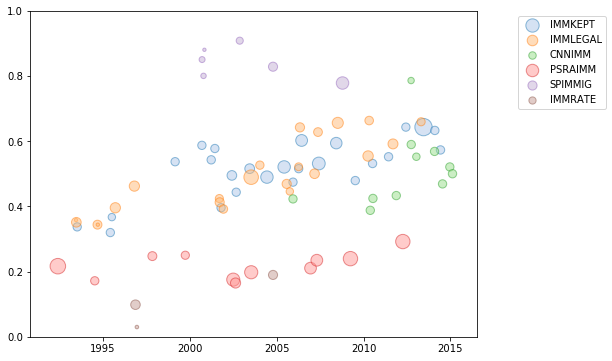

In [340]:
# load polls
reload(plotting)
reload(conversion)
from collections import Counter

polls = pd.read_csv(polls_file)

# convert date (strings) to Timestamp dates
#polls['date'] = [pd.Timestamp(d) for d in polls['Date']]
polls['date'] = [pd.Timestamp(dt.datetime.strptime(str(d), '%m/%d/%y')) for d in polls['Date']]
polls['f_date'] = conversion.dates_to_f_dates(polls['date'])
polls = polls[(polls.date > pd.Timestamp(year=1990, month=1, day=1)) & (polls.date < pd.Timestamp.today())]
polls['period'] = conversion.dates_to_periods(polls['date'], first_year, period=group_by)
polls = polls.sort_values(by='date')

print "Loaded %d polls" % len(polls.index)

# replace N for polls with N=0 with min poll size
print("%d polls with N=0" % len(polls[polls.N==0]))
min_nonzero_poll_size = polls.loc[polls.N > 0, 'N'].min()
print("min non-zero poll size = %d" % min_nonzero_poll_size)
print("Setting N=0 polls to N=%d" % min_nonzero_poll_size)
polls.loc[polls.N == 0, 'N'] = min_nonzero_poll_size

# scale the "Index" variable and rename it value
polls['value'] = polls['Index'] / 100.0

# add in indicator variables for each question
counter = Counter()
all_varnames = polls['Varname'].values
counter.update(all_varnames)
varnames_counts = counter.most_common(n=6)
varnames = []
for v, c in varnames_counts:
    polls[v] = 0
    polls.loc[polls.Varname == v, v] = 1
    varnames.append(v)
    
for v in list(set(all_varnames)):
    if v not in polls.columns:
        polls = polls.loc[polls.Varname != v]
    
print "Varnames = ", list(varnames)

plotting.plot_polling_data(polls);

In [341]:
"""
# drop outliers
polls = polls[polls.Varname != 'PSRAIMM']
polls = polls[polls.Varname != 'SPIMMIG']
index = polls[(polls.Varname == 'CNNIMM') & (polls.date < pd.Timestamp(year=2009, month=1, day=1))].index
print index
polls = polls.drop(index[0])
index = polls[(polls.Varname == 'CNNIMM') & (polls.value  > 0.7)].index
print index
polls = polls.drop(index[0])
plotting.plot_polling_data(polls);
""";

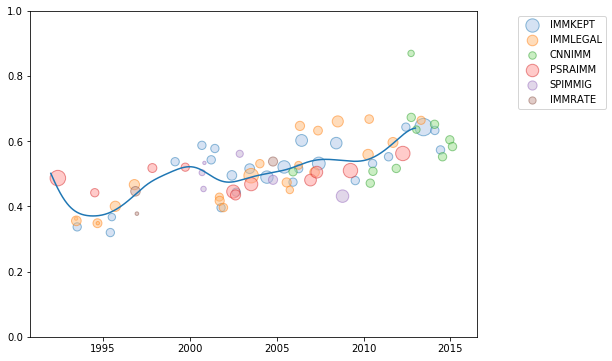

In [342]:
# use linear regression to compute offsets between polls
reload(smoothing)
from sklearn.linear_model import LinearRegression as LR

X = polls[varnames[1:] + ['f_date']]
y = polls['value']
model = LR()
model.fit(X, y)
polls['adjusted'] = polls['value']
for p_i, poll in enumerate(varnames[1:]):
    polls.loc[polls.Varname == poll, 'adjusted'] = polls.loc[polls.Varname == poll, 'adjusted'] - model.coef_[p_i]

#subset = polls[polls.Varname == 'IMMKEPT']
    
fit_f_dates = polls.f_date.ravel()
fit_values = polls.adjusted.ravel()
fit_weights = polls.N.ravel()
pred_range = grouped['f_date']

#fit = smoothing.local_linear(x=fit_f_dates, y=fit_values, pred_range=pred_range, bw=[1.0])
fit = smoothing.local_linear(x=fit_f_dates, y=fit_values, pred_range=pred_range)
#fit = smoothing.linear(x=fit_f_dates, y=fit_values, pred_range=pred_range, weights=fit_weights)

grouped['mood'] = fit

fig, ax = plotting.plot_polling_data(polls, column='adjusted');
ax.plot(pred_range, fit)

In [343]:
# do held out thing I'm not going to do anyway...
"""
reload(smoothing)
from sklearn.linear_model import LinearRegression as LR

X = polls[varnames[1:] + ['f_date']]
y = polls['value']
model = LR()
model.fit(X, y)
polls['adjusted'] = polls['value']
for p_i, poll in enumerate(varnames[1:]):
    polls.loc[polls.Varname == poll, 'adjusted'] = polls.loc[polls.Varname == poll, 'adjusted'] - model.coef_[p_i]

#subset = polls[polls.Varname == 'IMMKEPT']

fig, ax = plotting.plot_polling_data(polls, column='adjusted');

#pred_range = np.linspace(np.min(fit_f_dates), np.max(fit_f_dates), 1000)

window = 15 # days
predictions = []
poll_f_dates = []
for p_i, poll in enumerate(polls.index):
    date = polls.loc[poll, 'date']
    f_date = polls.loc[poll, 'f_date']
    poll_f_dates.append(f_date)
    subset_polls = polls[(polls['date'] < date - pd.Timedelta(days=30)) | (polls['date'] > date + pd.Timedelta(days=30))]
    subset_f_dates = subset_polls.f_date
    fit = smoothing.local_linear(x=subset_f_dates, y=subset_polls.adjusted, pred_range=pred_range, bw=[1.0])
    pred = smoothing.local_linear(x=subset_f_dates, y=subset_polls.adjusted, pred_range=[f_date], bw=[1.0])[0]
    predictions.append(pred)
    ax.plot(pred_range, fit, c='black', alpha=0.2)

ax.scatter(poll_f_dates, predictions, c='blue')
polls['predicted'] = predictions
""";


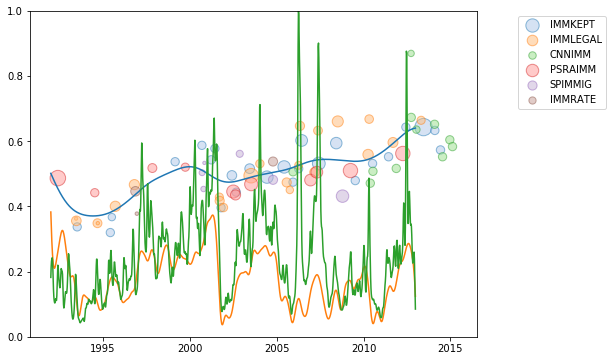

In [344]:

reload(smoothing)
from sklearn.linear_model import LinearRegression as LR

fig, ax = plotting.plot_polling_data(polls, column='adjusted');
ax.plot(grouped.f_date, grouped.mood)
ax.plot(grouped.f_date, grouped.tone_smooth)

#toneXstories = grouped['tone'] * grouped['stories']
#toneXstories_smooth = smoothing.local_linear(x=f_dates, y=toneXstories, pred_range=f_dates, bw=[0.25])
toneXstories_smooth = grouped.tone_smooth * grouped.stories_smooth
toneXstories_smooth /= float(np.max(toneXstories_smooth))
ax.plot(grouped.f_date, toneXstories_smooth)


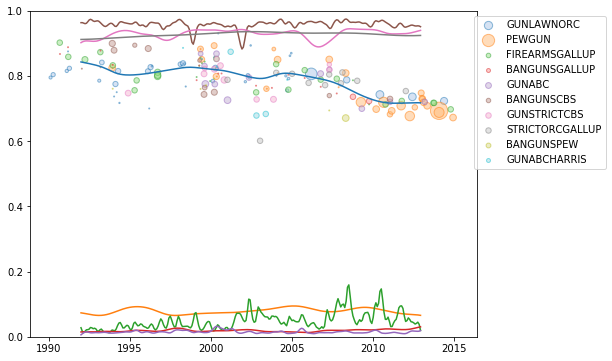

In [90]:
# use linear regression to compute offsets between polls
reload(smoothing)
from sklearn.linear_model import LinearRegression as LR

X = polls[varnames[1:] + ['f_date']]
y = polls['value']
model = LR()
model.fit(X, y)

#subset = polls[polls.Varname == 'IMMKEPT']
    
fit_f_dates = polls.f_date.ravel()
fit_values = polls.adjusted.ravel()
fit_weights = polls.N.ravel()
#pred_range = np.linspace(np.min(fit_f_dates), np.max(fit_f_dates), 1000)

fit = smoothing.local_linear(x=fit_f_dates, y=fit_values, pred_range=pred_range, bw=[1.0])
#fit = smoothing.linear(x=fit_f_dates, y=fit_values, pred_range=pred_range, weights=fit_weights)

fig, ax = plotting.plot_polling_data(polls, column='adjusted');
ax.plot(pred_range, fit)

political_pro_smooth = smoothing.local_linear(x=f_dates, y=grouped.Political_Pro, pred_range=f_dates)
ax.plot(f_dates, political_pro_smooth)
legality_pro_smooth = smoothing.local_linear(x=f_dates, y=grouped.Legality_jurisdiction_Pro, pred_range=f_dates)
ax.plot(f_dates, legality_pro_smooth)
culture_pro = smoothing.local_linear(x=f_dates, y=grouped.Cultural_identity_Pro, pred_range=f_dates)
ax.plot(f_dates, culture_pro)
public_pro = smoothing.local_linear(x=f_dates, y=grouped.Public_sentiment_Pro, pred_range=f_dates)
ax.plot(f_dates, public_pro)

security_anti = smoothing.local_linear(x=f_dates, y=grouped.Security_and_defense_Anti, pred_range=f_dates)
ax.plot(f_dates, 1 - security_anti)
crime_anti = smoothing.local_linear(x=f_dates, y=grouped.Crime_and_punishment_Anti, pred_range=f_dates)
ax.plot(f_dates, 1 - crime_anti)
political_anti = smoothing.local_linear(x=f_dates, y=grouped.Policy_prescription_Anti, pred_range=f_dates)
ax.plot(f_dates, 1 - political_anti)

In [353]:
def wavg(df, col, weight_col):
    return np.sum(df[col] * df[weight_col]) / df[weight_col].sum()

def wsum(df, col, weight_col):
    return np.sum(df[col] * df[weight_col])


In [357]:
# see if we can predict deviations from the linear fit based on tone in the previous time window
reload(smoothing)
reload(conversion)

time_window_periods = 2

# exclude polls after we have tone data
polls_subset = polls[(polls.date <= pd.Timestamp(year=last_year, month=12, day=31))].copy()
polls_subset = polls_subset.sort_values(by='date')

tones = []
pro = []
anti = []
pro_dom = []
anti_dom = []
n_stories = []
mood_diffs = []
entropy_pros = []
entropy_antis = []
entropy_vals = []
pro_max_gains = []
anti_max_gains = []

polls_subset['pro_max_frame'] = 0
polls_subset['pro_max_gain'] = 0
polls_subset['pro_max_gain_percent'] = 0
polls_subset['anti_max_frame'] = 0
polls_subset['anti_max_gain'] = 0
polls_subset['anti_max_gain_percent'] = 0
polls_subset['pro_dom'] = 0

for i, poll in enumerate(polls_subset.index):
    #date = subset.loc[poll, 'date']    
    period = polls_subset.loc[poll, 'period']
    #data_subset = data.loc[(data.date <= date) & (data.date > date - pd.Timedelta(days=time_window_days))]
    #prev_subset = data.loc[(data.date <=  date - pd.Timedelta(days=time_window_days)) & (data.date > date - pd.Timedelta(days=time_window_days*2))]      
    #curr_subset = data.loc[(data.period <= period) & (data.period > period - time_window_periods)]
    #prev_subset = data.loc[(data.period <= )]
    curr_grouped_subset = grouped.loc[(grouped.period <= period) & (grouped.period > period - time_window_periods)]
    prev_grouped_subset = grouped.loc[(grouped.period <= period - time_window_periods) & (grouped.period > period - 2 * time_window_periods)]

    pro_cols = [f + '_' + 'Pro' for f in FRAMES]
    anti_cols = [f + '_' + 'Anti' for f in FRAMES]

    # initialize these
    diff_mean = curr_grouped_subset.sum()
    diff_sum = curr_grouped_subset.sum()
    
    for c in (pro_cols + anti_cols):
        diff_mean[c] = wavg(curr_grouped_subset, c, 'stories') - wavg(prev_grouped_subset, c, 'stories')
        diff_sum[c] = wsum(curr_grouped_subset, c, 'stories') - wsum(prev_grouped_subset, c, 'stories')
           
    pro_max_frame = np.argmax(diff_sum[pro_cols])
    polls_subset.loc[poll, 'pro_max_frame'] = pro_max_frame
    polls_subset.loc[poll, 'pro_max_gain'] = diff_sum[pro_cols][pro_max_frame]
    polls_subset.loc[poll, 'pro_max_gain_percent'] = diff_mean[pro_cols][pro_max_frame]

    anti_max_frame = np.argmax(diff_sum[anti_cols])
    polls_subset.loc[poll, 'anti_max_frame'] = anti_max_frame
    polls_subset.loc[poll, 'anti_max_gain'] = diff_sum[anti_cols][anti_max_frame]
    polls_subset.loc[poll, 'anti_max_gain_percent'] = diff_mean[anti_cols][anti_max_frame]
    
    polls_subset.loc[poll, 'pro_dom'] = compute_dominance(polls_subset, t='Pro')
    polls_subset.loc[poll, 'anti_dom'] = compute_dominance(polls_subset, t='Anti')
    
    tones.append(wavg(curr_grouped_subset, 'tone_smooth', 'stories_smooth'))
    pro.append(wavg(curr_grouped_subset, 'Pro_smooth', 'stories_smooth'))
    anti.append(wavg(curr_grouped_subset, 'Anti_smooth', 'stories_smooth'))
    n_stories.append(curr_grouped_subset['stories_smooth'].sum())

print polls_subset['pro_dom']
    
#print subset[['f_date', 'pro_max_frame', 'pro_max_gain', 'pro_max_gain_percent']]

#subset['prev_mood'] = subset['mood'].shift().as_matrix()

#gap_days = time_window_days
#relevant_f_dates = np.array(subset.f_date) - gap_days/365.0
##pred = smoothing.linear(x=fit_f_dates, y=fit_values, pred_range=relevant_f_dates, weights=fit_weights)
#pred = smoothing.local_linear(x=gro[i, y=fit_values, pred_range=relevant_f_dates)

polls_subset['prev_mood'] = [grouped.loc[p - time_window_periods, 'mood'] for p in polls_subset.period]
polls_subset['tone'] = tones
polls_subset['stories'] = n_stories
polls_subset['pro'] = pro
polls_subset['anti'] = anti

#subset['pro_dom'] = pro_dom
#subset['anti_dom'] = anti_dom
polls_subset['max_gain_diff_percent'] = polls_subset['pro_max_gain_percent'] - polls_subset['anti_max_gain_percent']
polls_subset['max_gain_diff'] = polls_subset['pro_max_gain'] - polls_subset['anti_max_gain']
#subset['gainXstories'] = subset['stories_smooth'] * subset['max_gain_diff_percent']
#subset['toneXstories'] = subset['tone_smooth'] * subset['stories_smooth']
#polls_subset['gainXstories'] = polls_subset['stories'] * polls_subset['max_gain_diff_percent']
polls_subset['toneXstories'] = polls_subset['tone'] * polls_subset['stories']

polls_subset['target'] = polls_subset.adjusted  # - subset.predicted
#subset['target'] = subset.mood  #- subset.prev_mood


fitted, rmse, model = stats.ols(df=polls_subset, target='target', columns=['prev_mood'])
print model
fitted, rmse, model = stats.ols(df=polls_subset, target='target', columns=['prev_mood', 'tone'])
print model
fitted, rmse, model = stats.ols(df=polls_subset, target='target', columns=['prev_mood', 'tone', 'stories'])
print model
fitted, rmse, model = stats.ols(df=polls_subset, target='target', columns=['prev_mood', 'tone', 'stories', 'toneXstories'])
print model
fitted, rmse, model = stats.ols(df=polls_subset, target='target', columns=['prev_mood', 'toneXstories'])
print model

fitted, rmse, model = stats.ols(df=polls_subset, target='target', columns=['prev_mood', 'max_gain_diff_percent'])
print model
fitted, rmse, model = stats.ols(df=polls_subset, target='target', columns=['prev_mood', 'max_gain_diff_percent', 'stories'])
print model
fitted, rmse, model = stats.ols(df=polls_subset, target='target', columns=['prev_mood', 'max_gain_diff'])
print model 




68   NaN
43   NaN
44   NaN
16   NaN
69   NaN
45   NaN
46   NaN
17   NaN
18   NaN
47   NaN
48   NaN
65   NaN
66   NaN
70   NaN
19   NaN
71   NaN
20   NaN
79   NaN
80   NaN
81   NaN
21   NaN
22   NaN
49   NaN
50   NaN
23   NaN
51   NaN
24   NaN
72   NaN
73   NaN
25   NaN
      ..
54   NaN
55   NaN
0    NaN
29   NaN
56   NaN
30   NaN
57   NaN
31   NaN
75   NaN
58   NaN
76   NaN
59   NaN
32   NaN
33   NaN
60   NaN
84   NaN
77   NaN
34   NaN
61   NaN
62   NaN
1    NaN
35   NaN
2    NaN
36   NaN
63   NaN
3    NaN
78   NaN
37   NaN
4    NaN
5    NaN
Name: pro_dom, dtype: float64
Rmse: 0.0593146202977
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     103.4
Date:                Mon, 05 Jun 2017   Prob (F-statistic):           3.28e-15
Time

In [91]:

def compute_dominance(df, t='Pro', smooth=True):
    df_sum = df.sum()
    if smooth:
        cols = [c + '_' + t + '_smooth' for c in FRAMES]
    else:
        cols = [c + '_' + t for c in FRAMES]
    vals = df_sum[cols]
    order = np.argsort(vals)
    dom = vals[order[-1]] - vals[order[-2]]
    return dom

def compute_entropy(df):
    mean = df.mean()
    pro_cols = [c + '_Pro' for c in FRAMES]
    pro_vals = mean[pro_cols] / np.sum(mean[pro_cols])

    anti_cols = [c + '_Anti' for c in FRAMES]
    anti_vals = mean[anti_cols] / np.sum(mean[anti_cols])
    return entropy(pro_vals) - entropy(anti_vals)


In [117]:
# see if we can predict deviations from the linear fit based on tone in the previous time window
reload(smoothing)
reload(conversion)

time_window_days = 60

#subset = polls[(polls.date >= pd.Timestamp(year=first_year, month=1, day=1)) & (polls.date <= pd.Timestamp(year=last_year, month=12, day=31))].copy()

# exclude polls after we have tone data
subset = polls[(polls.date <= pd.Timestamp(year=last_year, month=12, day=31))].copy()
subset = subset.sort('date')
#first_poll_date = polls.f_date.min()
#subset = grouped[grouped['f_date'] >= first_poll_date].copy()
#subset = subset.sort_values(by='f_date')

tones = []
pro = []
anti = []
pro_dom = []
anti_dom = []
n_stories = []
mood_diffs = []
entropy_pros = []
entropy_antis = []
entropy_vals = []
pro_max_gains = []
anti_max_gains = []

subset['pro_max_frame'] = 0
subset['pro_max_gain'] = 0
subset['pro_max_gain_percent'] = 0
subset['anti_max_frame'] = 0
subset['anti_max_gain'] = 0
subset['anti_max_gain_percent'] = 0

#for i, period in enumerate(subset.index):
for i, poll in enumerate(subset.index):
    date = subset.loc[period, 'date']    
    data_subset = data.loc[(data.date <= date) & (data.date > date - pd.Timedelta(days=time_window_days))]
    prev_subset = data.loc[(data.date <=  date - pd.Timedelta(days=time_window_days)) & (data.date > date - pd.Timedelta(days=time_window_days*2))]      
    
    #pro_cols = [f + '_' + 'Pro_smooth' for f in FRAMES]

    diff_mean = data_subset.mean() - prev_subset.mean()
    diff_sum = data_subset.sum() - prev_subset.sum()
    pro_cols = [f + '_' + 'Pro' for f in FRAMES]
    anti_cols = [f + '_' + 'Anti' for f in FRAMES]
    
    #current_row = subset.loc[period, pro_cols]
    #previous_row = subset.loc[period-1, pro_cols]
    #diff_mean = current_row - previous_row
    #diff_sum = subset.loc[period, 'stories_smooth'] * current_row - subset.loc[period-1, 'stories_smooth'] * previous_row

    pro_max_frame = np.argmax(diff_sum[pro_cols])
    subset.loc[period, 'pro_max_frame'] = pro_max_frame
    subset.loc[period, 'pro_max_gain'] = diff_sum[pro_cols][pro_max_frame]
    subset.loc[period, 'pro_max_gain_percent'] = diff_mean[pro_cols][pro_max_frame]

    #anti_cols =  [f + '_' + 'Anti_smooth' for f in FRAMES]

    #current_row = subset.loc[period, anti_cols]
    #previous_row = subset.loc[period-1, anti_cols]
    #diff_mean = current_row - previous_row
    #diff_sum = subset.loc[period, 'stories_smooth'] * current_row - subset.loc[period-1, 'stories_smooth'] * previous_row

    anti_max_frame = np.argmax(diff_sum[anti_cols])
    subset.loc[period, 'anti_max_frame'] = anti_max_frame
    subset.loc[period, 'anti_max_gain'] = diff_sum[anti_cols][anti_max_frame]
    subset.loc[period, 'anti_max_gain_percent'] = diff_mean[anti_cols][anti_max_frame]
    
    tones.append(data_subset['tone'].mean())
    pro.append(data_subset['Pro'].mean())
    anti.append(data_subset['Anti'].mean())
    #pro_dom.append(compute_dominance(data_subset, 'Pro'))
    #anti_dom.append(compute_dominance(data_subset, 'Anti'))
    n_stories.append(data_subset['stories'].sum())
    
#print subset[['f_date', 'pro_max_frame', 'pro_max_gain', 'pro_max_gain_percent']]

#subset['prev_mood'] = subset['mood'].shift().as_matrix()

gap_days = time_window_days
relevant_f_dates = np.array(subset.f_date) - gap_days/365.0
#pred = smoothing.linear(x=fit_f_dates, y=fit_values, pred_range=relevant_f_dates, weights=fit_weights)
pred = smoothing.local_linear(x=fit_f_dates, y=fit_values, pred_range=relevant_f_dates)

subset['prev_mood'] = pred
subset['tone'] = tones
subset['stories'] = n_stories
subset['pro'] = pro
subset['anti'] = anti

#subset['pro_dom'] = pro_dom
#subset['anti_dom'] = anti_dom
subset['max_gain_diff_percent'] = subset['pro_max_gain_percent'] - subset['anti_max_gain_percent']
#subset['gainXstories'] = subset['stories_smooth'] * subset['max_gain_diff_percent']
#subset['toneXstories'] = subset['tone_smooth'] * subset['stories_smooth']
subset['gainXstories'] = subset['stories'] * subset['max_gain_diff_percent']
subset['toneXstories'] = subset['tone'] * subset['stories']


subset['target'] = subset.adjusted# - subset.predicted
#subset['target'] = subset.mood #- subset.prev_mood


fitted, rmse, model = stats.ols(df=subset, target='target', columns=['prev_mood'])
print model
fitted, rmse, model = stats.ols(df=subset, target='target', columns=['prev_mood', 'tone_smooth'])
print model
fitted, rmse, model = stats.ols(df=subset, target='target', columns=['prev_mood', 'tone_smooth', 'stories_smooth'])
print model
fitted, rmse, model = stats.ols(df=subset, target='target', columns=['prev_mood', 'tone_smooth', 'stories_smooth', 'toneXstories'])
print model
fitted, rmse, model = stats.ols(df=subset, target='target', columns=['prev_mood', 'toneXstories'])
print model

fitted, rmse, model = stats.ols(df=subset, target='target', columns=['prev_mood', 'max_gain_diff_percent'])
print model
fitted, rmse, model = stats.ols(df=subset, target='target', columns=['prev_mood', 'max_gain_diff_percent', 'stories_smooth'])
print model
fitted, rmse, model = stats.ols(df=subset, target='target', columns=['prev_mood', 'max_gain_diff_percent', 'stories_smooth', 'gainXstories'])
print model 
fitted, rmse, model = stats.ols(df=subset, target='target', columns=['prev_mood', 'gainXstories'])
print model 


#fitted, rmse, model = stats.ols(df=subset, target='target', columns=['toneXstories', 'max_gain_diff'])
#print model





/Users/dcard/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  # This is added back by InteractiveShellApp.init_path()


Rmse: 0.051277404015
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     225.0
Date:                Mon, 05 Jun 2017   Prob (F-statistic):           1.12e-34
Time:                        13:00:47   Log-Likelihood:                 317.52
No. Observations:                 204   AIC:                            -631.0
Df Residuals:                     202   BIC:                            -624.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0042      0.02

KeyError: "['tone_smooth'] not in index"

In [44]:
# get all dates
groups = data.groupby('date')
grouped = pd.DataFrame()
grouped['stories'] = groups.aggregate(np.sum)['stories']
dates = grouped.index

# get the tone and number of stories in the preceeding time window (of size time_window_days)
n_dates = len(dates)
tone = np.zeros(n_dates)
n_stories = np.zeros(n_dates)

for d_i, d in enumerate(dates):
    subset = data.loc[(data.date <= d) & (data.date > d - pd.Timedelta(days=time_window_days))]
    tone[d_i] = subset['tone'].mean()
    n_stories[d_i] = subset['stories'].sum()

    if d_i % 1000 == 0 and d_i > 0:
        print d_i
    

1000
2000
3000
4000
5000
6000
7000


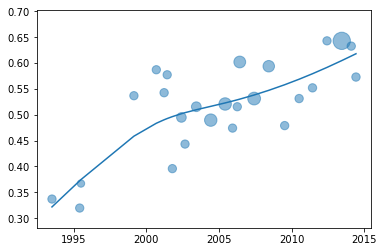

In [156]:
# choose a single poll and plot a linear fit
reload(smoothing)

subset = polls[polls.Varname == 'IMMKEPT']

scale = 300.0
fit_f_dates = conversion.dates_to_f_dates(subset.date)
fit_values = subset.value.copy()

fit = smoothing.local_linear(x=fit_f_dates, y=fit_values, pred_range=fit_f_dates)

fig, ax = plt.subplots()
ax.scatter(fit_f_dates, fit_values, s=scale * subset.N / float(np.max(subset.N)), alpha=0.5)
ax.plot(fit_f_dates, fit)